In [30]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
data_dir = './data'
output_dir = './plots'

# TP53 mutations

In [32]:
table_file = os.path.join(data_dir,'TP53_merged_data.tsv')

In [33]:
table = pd.read_csv(table_file,sep='\t')

In [34]:
table['consequence_normal'].value_counts()

consequence_normal
missense                  323
intron_variant            310
nonsense                   83
synonymous                 37
splice_region_variant      35
essential_splice           24
non_coding_exon_region     18
Name: count, dtype: int64

In [35]:
def group_normal_consequence(r):
    if r['consequence_normal'] == 'missense':
        return 'missense'
    elif r['consequence_normal'] == 'nonsense' or r['consequence_normal'] == 'essential_splice':
        return 'truncating'
    elif r['consequence_normal'] == 'synonymous':
        return 'synonymous'
    elif r['consequence_normal'] == 'intron_variant' or r['consequence_normal'] == 'non_coding_exon_region':
        return 'noncoding'
    elif r['consequence_normal'] == 'splice_region_variant':
        return 'other'
    else:
        return 'not_observed'

In [36]:
table['consequence_normal_formatted'] = table.apply(group_normal_consequence,axis=1)

In [37]:
table['consequence_normal_formatted'].value_counts()

consequence_normal_formatted
not_observed    4609
noncoding        328
missense         323
truncating       107
synonymous        37
other             35
Name: count, dtype: int64

In [38]:
list(table.columns)

['chr',
 'pos',
 'ref',
 'alt',
 'consequence_intogen',
 'count_intogen_cancer',
 'count_intogen_bladder',
 'consequence_genie',
 'count_genie',
 'freq_genie',
 'count_bladder_genie',
 'freq_bladder_genie',
 'boostdm_score_cancer',
 'boostdm_class_cancer',
 'boostdm_score_bladder',
 'boostdm_class_bladder',
 'oncogenic',
 'consequence_normal',
 'count_normal',
 'freq_intogen_cancer',
 'freq_intogen_bladder',
 'freq_normal',
 'site_selection',
 'p_value',
 'RFS',
 'p',
 'consequence_normal_formatted']

In [39]:
def group(r):
    if r['consequence_normal_formatted'] == 'not_observed':
        return 'not_observed'
    elif r['p_value'] < 1e-5:
        return 'significant'
    elif r['p_value'] >= 1e-5:
        return 'not_significant'
    

In [40]:
table['group_normal'] = table.apply(group,axis=1)

In [41]:
table['oncogenic'] = table['oncogenic'].fillna(0)
oncogenic_data = table.groupby(['group_normal','oncogenic'])['chr'].count().reset_index().pivot(index='group_normal',columns='oncogenic',values='chr').reset_index()
oncogenic_values = oncogenic_data.to_dict()
oncogenic_data['N'] = oncogenic_data[0.0] / (oncogenic_data[0.0] + oncogenic_data[1.0])
oncogenic_data['Y'] = oncogenic_data[1.0] / (oncogenic_data[0.0] + oncogenic_data[1.0])
oncogenic_data = oncogenic_data.drop([0.0,1.0],axis=1)

In [42]:
oncogenic_values

{'group_normal': {0: 'not_observed', 1: 'not_significant', 2: 'significant'},
 0.0: {0: 3653, 1: 160, 2: 2},
 1.0: {0: 956, 1: 217, 2: 38}}

In [43]:
table['group_normal'].value_counts()

group_normal
not_observed       4609
not_significant     377
significant          40
Name: count, dtype: int64

In [44]:
table.groupby(by='group_normal')['freq_intogen_bladder'].mean()

group_normal
not_observed       0.000039
not_significant    0.000236
significant        0.004123
Name: freq_intogen_bladder, dtype: float64

# site selection groups as independent variable

In [45]:
size_groups = pd.DataFrame({'size':table.groupby(by='group_normal')['chr'].count()}).reset_index()

In [46]:
size_groups

,group_normal,size
0,not_observed,4609
1,not_significant,377
2,significant,40


In [47]:
# Define the custom color palette
custom_palette = {
    'significant': 'blue',       # Blue for significant
    'not_significant': '#6baed6',  # Lighter blue for not significant
    'not_observed': 'gray'       # Gray for not observed
}


/tmp/ipykernel_275393/3881537102.py:45: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=table,


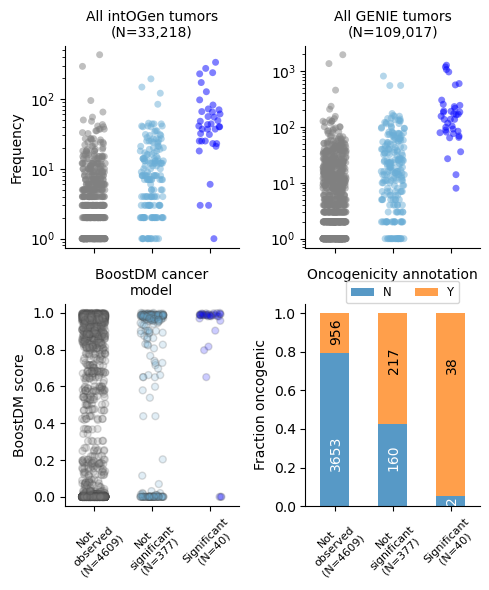

In [48]:
TP53_whole_figure = os.path.join(output_dir,'ExtendedFig10b_TP53_multipanel_saturation.png')

fig, axs = plt.subplots(2, 2, figsize=(5,6), sharex=True)

#Frequency intogen cancer
sns.stripplot(data=table,
              x='group_normal',
              y='count_intogen_cancer',
              jitter=0.2,
              hue='group_normal',
              alpha=0.5,
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_xlabel('')
axs[0,0].set_title('All intOGen tumors\n(N=33,218)', fontsize = 10)
axs[0,0].spines[['top','right']].set_visible(False)

#Frequency GENIE cancer
sns.stripplot(data=table,
              x='group_normal',
              y='count_genie',
              jitter=0.2,
              hue='group_normal',
              alpha=0.5,
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[0,1])
axs[0,1].get_legend().remove()
axs[0,1].set_yscale('log')
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')
axs[0,1].set_title('All GENIE tumors\n(N=109,017)', fontsize = 10)
axs[0,1].spines[['top','right']].set_visible(False)


#BoostDM cancer scores
sns.stripplot(data=table,
              x='group_normal',
              y='boostdm_score_cancer',
              jitter=0.2,
              hue='group_normal',
              alpha=0.2,
              size=5,              
              edgecolor='gray',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[1,0])

axs[1,0].get_legend().remove()
axs[1,0].set_ylabel('BoostDM score')
axs[1,0].set_xlabel('')
axs[1,0].set_xticks([0,1,2],
                    ['Not\nobserved\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_observed']['size'].values[0]) + ')',
                    'Not\nsignificant\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_significant']['size'].values[0]) + ')',
                    'Significant\n(N=' + str(size_groups[size_groups['group_normal'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8
                   )
axs[1,0].set_title('BoostDM cancer\nmodel', fontsize = 10)
axs[1,0].spines[['top','right']].set_visible(False)

#Oncogenic counts
oncogenic_data.plot(kind='bar', 
                    stacked=True, 
                    alpha=0.75,
                    ax=axs[1,1])
axs[1,1].legend(ncol=2,bbox_to_anchor=(0.2,1.14),
               loc='upper left', fontsize='small'
               # , frameon = False
               )
axs[1,1].set_ylabel('Fraction oncogenic')
axs[1,1].set_xlabel('')
axs[1,1].set_xticks([0,1,2],
                    ['Not\nobserved\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_observed']['size'].values[0]) + ')',
                    'Not\nsignificant\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_significant']['size'].values[0]) + ')',
                    'Significant\n(N=' + str(size_groups[size_groups['group_normal'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8
                   )
axs[1,1].set_title('Oncogenicity annotation', fontsize = 10, pad = 18)
axs[1,1].spines[['top','right']].set_visible(False)

axs[1,1].text(-0.1, 0.2, str(oncogenic_values[0.0][0]), fontdict=None, color='white', rotation=90)
axs[1,1].text(-0.1, 0.85, str(oncogenic_values[1.0][0]), fontdict=None, color='black', rotation=90)
axs[1,1].text(0.9, 0.2, str(oncogenic_values[0.0][1]), fontdict=None, color='white', rotation=90)
axs[1,1].text(0.9, 0.7, str(oncogenic_values[1.0][1]), fontdict=None, color='black', rotation=90)
axs[1,1].text(1.9, 0.02, str(oncogenic_values[0.0][2]), fontdict=None, color='white', rotation=90)
axs[1,1].text(1.9, 0.7, str(oncogenic_values[1.0][2]), fontdict=None, color='black', rotation=90)

plt.tight_layout()
plt.savefig(TP53_whole_figure)

# TERT promoter mutations

In [49]:
table_file = os.path.join(data_dir,'TERT_merged_data.tsv')
table = pd.read_csv(table_file,sep='\t')
table = table[table['Variant_Type']=='SNP']

In [50]:
table

,chr,pos,ref,alt,count_normal,site_selection,p_value,count_tumor,freq_tumor,Consequence,Variant_Type,mut_patients,mut_freq,mut_bladder,mut_bladder_freq,value,p,system
0,chr5,1294947,C,T,0.0,NaN,NaN,0.0,0.000000,missense_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN
2,chr5,1294949,T,G,0.0,NaN,NaN,0.0,0.000000,missense_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN
4,chr5,1294955,C,G,0.0,NaN,NaN,0.0,0.000000,missense_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN
5,chr5,1294957,C,G,0.0,NaN,NaN,0.0,0.000000,synonymous_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN
6,chr5,1294958,C,T,0.0,NaN,NaN,1.0,0.000123,missense_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,chr5,1295283,T,C,0.0,NaN,NaN,0.0,0.000000,upstream_gene_variant,SNP,3.0,0.000027,0.0,0.0,NaN,NaN,NaN
2017,chr5,1295284,C,G,0.0,NaN,NaN,0.0,0.000000,upstream_gene_variant,SNP,3.0,0.000027,0.0,0.0,NaN,NaN,NaN
2018,chr5,1295285,C,T,0.0,NaN,NaN,0.0,0.000000,upstream_gene_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN
2019,chr5,1295286,C,T,1.0,103.377375,0.009627,0.0,0.000000,upstream_gene_variant,SNP,2.0,0.000018,0.0,0.0,NaN,NaN,NaN


In [51]:
def group_TERT(r):
    if r['count_normal'] == 0:
        return 'not_observed'
    elif r['p_value'] < 1e-5:
        return 'significant'
    elif r['p_value'] >= 1e-5:
        return 'not_significant'

In [52]:
table['group'] = table.apply(group_TERT,axis=1)

In [53]:
size_groups = pd.DataFrame({'size':table.groupby(by='group')['chr'].count()}).reset_index()

In [54]:
size_groups

,group,size
0,not_observed,389
1,not_significant,21
2,significant,12


In [55]:
table

,chr,pos,ref,alt,count_normal,site_selection,p_value,count_tumor,freq_tumor,Consequence,Variant_Type,mut_patients,mut_freq,mut_bladder,mut_bladder_freq,value,p,system,group
0,chr5,1294947,C,T,0.0,NaN,NaN,0.0,0.000000,missense_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN,not_observed
2,chr5,1294949,T,G,0.0,NaN,NaN,0.0,0.000000,missense_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN,not_observed
4,chr5,1294955,C,G,0.0,NaN,NaN,0.0,0.000000,missense_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN,not_observed
5,chr5,1294957,C,G,0.0,NaN,NaN,0.0,0.000000,synonymous_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN,not_observed
6,chr5,1294958,C,T,0.0,NaN,NaN,1.0,0.000123,missense_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN,not_observed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,chr5,1295283,T,C,0.0,NaN,NaN,0.0,0.000000,upstream_gene_variant,SNP,3.0,0.000027,0.0,0.0,NaN,NaN,NaN,not_observed
2017,chr5,1295284,C,G,0.0,NaN,NaN,0.0,0.000000,upstream_gene_variant,SNP,3.0,0.000027,0.0,0.0,NaN,NaN,NaN,not_observed
2018,chr5,1295285,C,T,0.0,NaN,NaN,0.0,0.000000,upstream_gene_variant,SNP,1.0,0.000009,0.0,0.0,NaN,NaN,NaN,not_observed
2019,chr5,1295286,C,T,1.0,103.377375,0.009627,0.0,0.000000,upstream_gene_variant,SNP,2.0,0.000018,0.0,0.0,NaN,NaN,NaN,not_significant


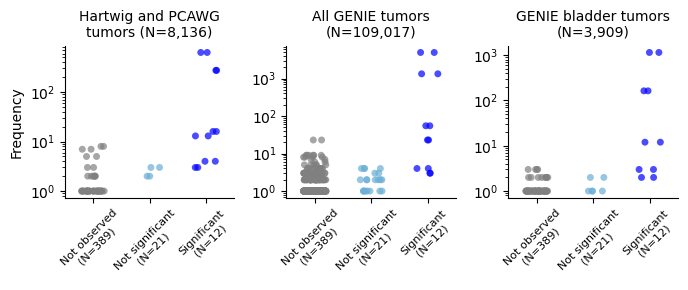

In [56]:
TERT_multipanel_saturation_fig = os.path.join(output_dir,'ExtendedFig10d_TERTp_selection_comparisons.png')

fig, axs = plt.subplots(1, 3, figsize=(7,3), sharex=True)

#Frequency cancer
sns.stripplot(data=table,
              x='group',
              y='count_tumor',
              jitter=0.2,
              hue='group',
              alpha=0.7,
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[0])
axs[0].legend([], [], frameon=False)
axs[0].set_yscale('log')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('')
axs[0].set_title('Hartwig and PCAWG\ntumors (N=8,136)', fontsize = 10)
axs[0].spines[['top','right']].set_visible(False)
axs[0].set_xticks([0,1,2],
               ['Not observed\n(N=' + str(size_groups[size_groups['group'] == 'not_observed']['size'].values[0]) + ')',
                'Not significant\n(N=' + str(size_groups[size_groups['group'] == 'not_significant']['size'].values[0]) + ')',
                'Significant\n(N=' + str(size_groups[size_groups['group'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8)



#Frequency GENIE cancer
sns.stripplot(data=table,
              x='group',
              y='mut_patients',
              jitter=0.2,
              hue='group',
              alpha=0.7,
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[1])
              
axs[1].legend([], [], frameon=False)
axs[1].set_yscale('log')
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_title('All GENIE tumors\n(N=109,017)', fontsize = 10)
axs[1].spines[['top','right']].set_visible(False)
axs[1].set_xticks([0,1,2],
               ['Not observed\n(N=' + str(size_groups[size_groups['group'] == 'not_observed']['size'].values[0]) + ')',
                'Not significant\n(N=' + str(size_groups[size_groups['group'] == 'not_significant']['size'].values[0]) + ')',
                'Significant\n(N=' + str(size_groups[size_groups['group'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8)


#Frequency GENIE bladder
sns.stripplot(data=table,
              x='group',
              y='mut_bladder',
              jitter=0.2,
              hue='group',
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              alpha=0.7,
              ax=axs[2])
axs[2].legend([], [], frameon=False)
axs[2].set_yscale('log')
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_xticks([0,1,2],
               ['Not observed\n(N=' + str(size_groups[size_groups['group'] == 'not_observed']['size'].values[0]) + ')',
                'Not significant\n(N=' + str(size_groups[size_groups['group'] == 'not_significant']['size'].values[0]) + ')',
                'Significant\n(N=' + str(size_groups[size_groups['group'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8)
axs[2].set_title('GENIE bladder tumors\n(N=3,909)', fontsize = 10)
axs[2].spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(TERT_multipanel_saturation_fig)